In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image, ImageOps, ImageDraw
from create_dataset import ClimbingHoldDataset
from collections import defaultdict
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from pycocotools import mask as maskUtils

In [28]:
hues = np.load('hues.npy').reshape(-1,1)

# Create the dataset
dataset = ClimbingHoldDataset(
    annotations_dir="data/annotations", 
    images_dir="data/images"
)

dataset.add_color(hues)


dataset.add_pred_indices_from_arrays("pred_type_idx.npy", "pred_orient_idx.npy")

dataset_pd = pd.DataFrame(dataset.holds)
dataset_pd.head()


,image_id,type,route_id,orientation,bbox,segmentation,color,pred_type_idx,pred_orient_idx
0,IMG_8293.jpeg,Jug,201.0,UpAng,"[1307.0, 233.0, 425.0, 403.0]","{'counts': [5270210, 9, 4020, 19, 4011, 24, 40...",43.859815,0,0
1,IMG_8293.jpeg,Jib,201.0,UpAng,"[666.0, 2583.0, 170.0, 156.0]","{'counts': [2687974, 10, 4013, 26, 4003, 35, 3...",77.539466,0,0
2,IMG_8293.jpeg,Jib,201.0,UpAng,"[482.0, 3055.0, 176.0, 155.0]","{'counts': [1946558, 23, 4001, 35, 3994, 40, 3...",55.375041,0,3
3,IMG_8293.jpeg,Jib,201.0,UpAng,"[461.0, 3563.0, 176.0, 148.0]","{'counts': [1862383, 29, 4000, 36, 3993, 42, 3...",68.240997,0,3
4,IMG_8293.jpeg,Jib,201.0,Up,"[1761.0, 3261.0, 117.0, 78.0]","{'counts': [7103636, 15, 4014, 21, 4009, 25, 4...",42.978590,0,0


In [29]:
img_list = dataset_pd['image_id'].unique()

In [30]:
kmeans = KMeans(init="random", 
                n_clusters=3, 
                n_init=10, 
                max_iter=300, 
                random_state=42)

In [31]:
img_id = img_list[1]
img_dataset = dataset_pd[(dataset_pd['image_id'] == img_id)]

In [32]:
route_list = img_dataset['route_id'].unique()
print(route_list)

[203. 204. 202.]


In [33]:
features = img_dataset['color'].to_numpy().reshape(-1,1)
types  = img_dataset['pred_type_idx'].to_numpy().reshape(-1, 1)

features = np.hstack([features, types])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)
preds = kmeans.labels_

img_dataset = img_dataset.copy()
img_dataset["cluster"] = preds

print("\n=== K-MEANS CLUSTER ASSIGNMENTS (color + predicted type) ===")
print(img_dataset[["color", "pred_type_idx", "cluster"]])

print("\nUnique clusters:", img_dataset["cluster"].unique())

print("\nCounts per cluster:")
print(img_dataset["cluster"].value_counts())


=== K-MEANS CLUSTER ASSIGNMENTS (color + predicted type) ===
         color  pred_type_idx  cluster
15   13.630610              6        0
16    9.607370              3        0
17   12.751141              0        1
18   13.124238              0        1
19   10.862960              0        1
20    8.416667              0        1
21    6.585574              3        0
22    4.224040              3        0
23    5.616832              3        0
24    5.452741              3        0
25    6.723280              3        0
26    6.288443              3        0
27   11.422604              3        0
28    9.164354              0        1
29    8.613927              0        1
30   13.948393              0        1
31   10.504164              0        1
32   12.500033              6        0
33    9.796598              0        1
34    7.511018              3        0
35   13.004683              3        0
36   10.885848              0        1
37    8.385723              0        1
38

In [34]:
def display_masked_image(img_path, rles):
    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)

    h, w = img.shape[:2]

    combined_mask = np.zeros((h, w), dtype=np.uint8)

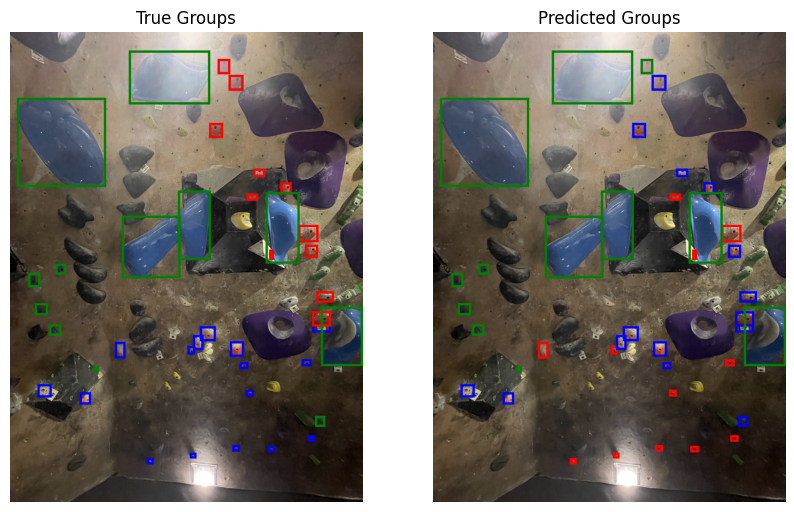

In [35]:
images_dir = 'data/images'
img_path = os.path.join(images_dir, img_id)

img = Image.open(img_path).convert("RGB")
img = ImageOps.exif_transpose(img)

image_with_boxes_pred = img.copy()
draw_pred = ImageDraw.Draw(image_with_boxes_pred)

colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'purple'}

for i, bbox in enumerate(img_dataset['bbox']):
    x, y, width, height = bbox
    label = preds[i]
    color = colors[label]
    draw_pred.rectangle([x, y, x + width, y + height], outline=color, width=20)

image_with_boxes_true = img.copy()
draw_true = ImageDraw.Draw(image_with_boxes_true)

colors = {202:'green', 203:'blue', 204:'red', 3:'yellow', 4:'purple'}

for route, bbox in zip(img_dataset['route_id'], img_dataset['bbox']):
    x, y, width, height = bbox
    label = route
    color = colors[label]
    draw_true.rectangle([x, y, x + width, y + height], outline=color, width=20)

# Display the image with bounding boxes
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(image_with_boxes_true)
ax[0].set_title("True Groups")
ax[0].axis("off")
ax[1].imshow(image_with_boxes_pred)
ax[1].set_title("Predicted Groups")
ax[1].axis("off")
plt.show()



In [36]:
def visualize_hues(hues):
    for H in hues[:100]:
        # Make a strip of HSV values where hue = your hue
        hsv_strip = np.zeros((50, 200, 3), dtype=np.uint8)
        hsv_strip[..., 0] = H      # Hue
        hsv_strip[..., 1] = 255    # Full saturation
        hsv_strip[..., 2] = 255    # Full brightness

        # Convert to RGB for proper display
        rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

        plt.figure(figsize=(2,2))
        plt.imshow(rgb_strip)
        plt.title(f"Hue = {H}")
        plt.axis('off')
        plt.show()

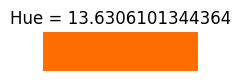

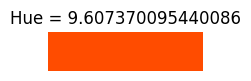

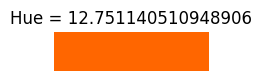

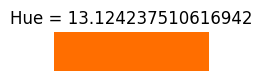

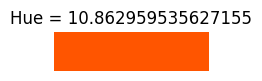

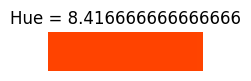

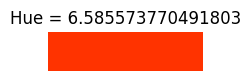

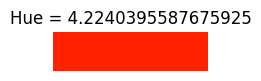

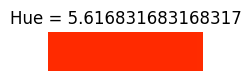

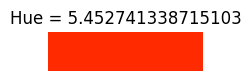

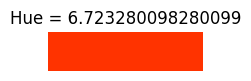

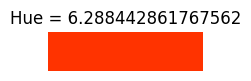

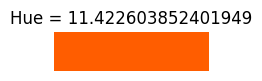

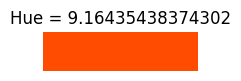

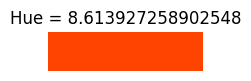

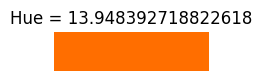

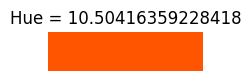

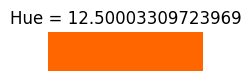

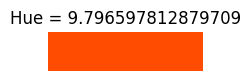

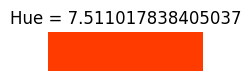

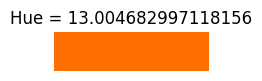

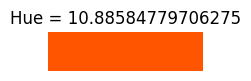

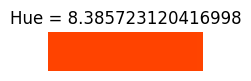

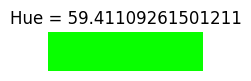

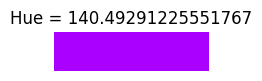

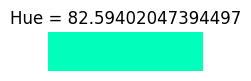

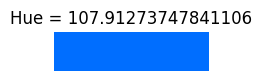

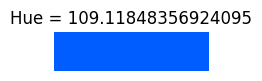

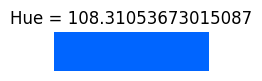

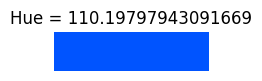

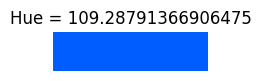

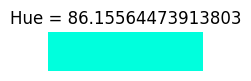

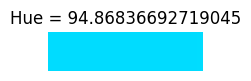

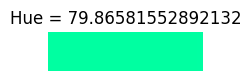

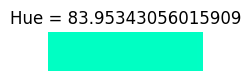

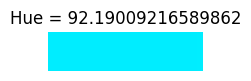

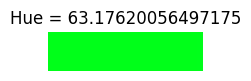

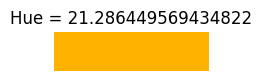

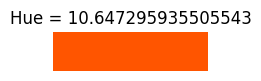

In [37]:
visualize_hues(img_dataset["color"].values)


In [38]:
from collections import defaultdict

holds_by_image = defaultdict(list)

for hold in dataset.holds:
    holds_by_image[hold["image_id"]].append(hold)


In [44]:
from collections import defaultdict

holds_by_image = defaultdict(list)
for hold in dataset.holds:
    holds_by_image[hold["image_id"]].append(hold)

def print_sample_hold(sample):
    TYPE_NAMES = ['Jug', 'Sloper', 'Crimp', 'Jib', 'Pinch', 'Pocket', 'Edge']
    ORIENT_NAMES = ['Up', 'Down', 'Side', 'UpAng', 'DownAng']

    print("\nSample Hold (PREDICTED):")
    print(f"Route ID (GT): {sample['route_id']}")
    print(f"Predicted Type: {TYPE_NAMES[sample['pred_type_idx']]}")
    print(f"Predicted Orientation: {ORIENT_NAMES[sample['pred_orient_idx']]}")
    print(f"Color: {sample['color']}")


print_sample_hold(holds_by_image['IMG_7280.JPG'][2])



Sample Hold (PREDICTED):
Route ID (GT): 2.0
Predicted Type: Jug
Predicted Orientation: UpAng
Color: 110.85855325612303
